In [407]:
%matplotlib inline

In [408]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')


In [409]:
import glob
import os

def get_latest_file_glob(pat):    
    list_of_files = glob.glob(pat) # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

In [410]:
latest_niv = get_latest_file_glob('data/corona_tested_individuals_ver_*.csv.gz')
niv = pd.read_csv(latest_niv, 
                  encoding='utf-8-sig', low_memory=False, na_values=['None'],
                  parse_dates=[0])
#niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-07-23,0,0,0,0,0,שלילי,No,זכר,Other
1,2020-07-23,0,0,0,0,0,שלילי,No,זכר,Other
2,2020-07-23,0,0,0,0,0,שלילי,No,נקבה,Other
3,2020-07-23,0,0,0,0,0,חיובי,No,נקבה,Other
4,2020-07-23,0,0,0,0,0,חיובי,No,נקבה,Other


In [411]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [412]:
latest_bdi = get_latest_file_glob('data/corona_lab_tests_ver_*.csv.gz')
bdi = pd.read_csv(latest_bdi, encoding='utf-8', parse_dates=[0,1])

In [413]:
bdi['orig_test_date'] = bdi.test_date
bdi['test_date'] = bdi.test_date.combine_first(bdi.result_date)

In [414]:
bdi.head()

,test_date,result_date,corona_result,lab_id,is_first_Test,orig_test_date
0,2020-03-18,2020-03-18,חיובי,32,No,NaT
1,2020-03-18,2020-03-18,חיובי,1,No,NaT
2,2020-03-20,2020-03-20,שלילי,4,Yes,NaT
3,2020-03-20,2020-03-20,שלילי,4,Yes,NaT
4,2020-03-20,2020-03-20,שלילי,4,Yes,NaT


In [415]:
bdi.shape

(1591234, 6)

In [416]:
bdi.corona_result.value_counts()

שלילי               1467935
חיובי                 92284
לא בוצע/פסול 999      17861
חיובי גבולי           12160
בעבודה                  596
לא ודאי                 398
Name: corona_result, dtype: int64

In [417]:
niv.corona_result.value_counts()

שלילי    1037699
חיובי      51113
אחר        13910
Name: corona_result, dtype: int64

In [418]:
niv.test_indication.value_counts()

Other                     1042875
Contact with confirmed      31786
Abroad                      28061
Name: test_indication, dtype: int64

In [419]:
niv.age_60_and_above.value_counts()

No     538651
Yes     79538
Name: age_60_and_above, dtype: int64

In [420]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [421]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [422]:
bdi['corona_result'] = bdi.corona_result.map(result_map)

In [423]:
rec = pd.read_csv(get_latest_file_glob('data/corona_recovered_ver_*.csv.gz'), encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,19,9,40-49,זכר,Abroad
1,22,9,30-39,זכר,Contact with confirmed
2,26,9,30-39,זכר,Contact with confirmed
3,28,9,30-39,נקבה,Abroad
4,23,9,20-29,נקבה,Contact with confirmed


In [424]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

,total_tests_count,size,min,max,mean,median,test_sum
0,2,6,6,17,12.833333,13,12
1,3,11061,2,112,16.665582,17,33183
2,4,5081,2,114,21.462114,21,20324
3,5,3127,2,106,24.647905,25,15635
4,6,1786,6,96,27.668533,27,10716
5,7,1063,8,108,30.398871,30,7441
6,8,597,3,103,33.475712,33,4776
7,9,357,3,78,35.700280,35,3213
8,10,573,5,106,41.130890,41,5730


In [425]:
rec.iloc[rec.days_between_pos_and_neg.nlargest(10).index]


,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
9432,114,4,60+,זכר,Other
12342,112,3,30-39,זכר,Contact with confirmed
9304,111,4,20-29,זכר,Other
1600,108,7,40-49,נקבה,Contact with confirmed
6311,106,5,30-39,זכר,Contact with confirmed
23175,106,10+,0-19,נקבה,Contact with confirmed
9696,105,4,30-39,נקבה,Other
456,103,8,50-59,נקבה,Contact with confirmed
20936,103,3,0-19,זכר,Abroad
23273,100,10+,60+,זכר,Contact with confirmed


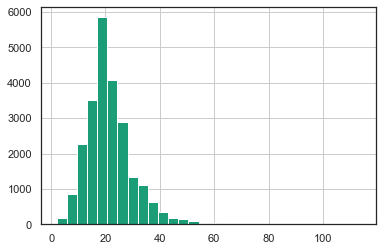

In [426]:
rec.days_between_pos_and_neg.hist(bins=30)

In [427]:
iso = pd.read_csv(get_latest_file_glob('data/corona_isolation_per_day_ver_*.csv.gz'),
                  encoding='utf-8-sig', low_memory=False)
iso.head()

,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad
0,2020-07-22,38275,8426,5929,753
1,2020-07-21,38633,8310,5390,669
2,2020-07-20,39052,8250,5508,731
3,2020-07-19,39080,8189,6919,736
4,2020-07-18,38175,8116,3161,294


In [428]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int32
no_symp                          bool
dtype: object

In [429]:
niv.age_60_and_above.value_counts()

No     538651
Yes     79538
Name: age_60_and_above, dtype: int64

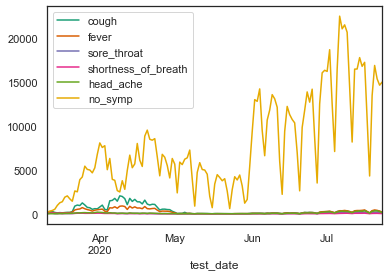

In [430]:
niv.groupby('test_date')[symptom_cols].sum().plot()

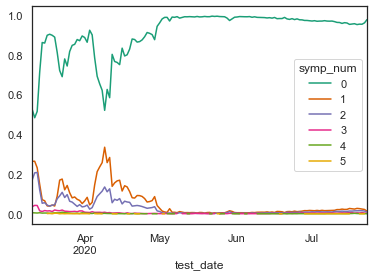

In [431]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

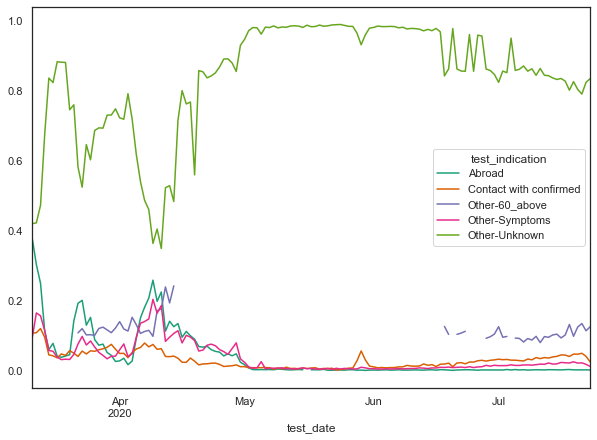

In [432]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

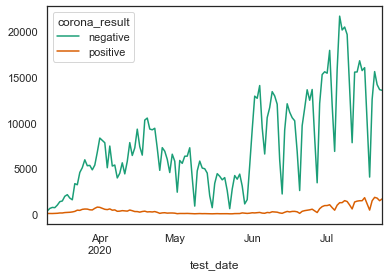

In [433]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [434]:
bdi.dtypes

test_date         datetime64[ns]
result_date       datetime64[ns]
corona_result             object
lab_id                     int64
is_first_Test             object
orig_test_date    datetime64[ns]
dtype: object

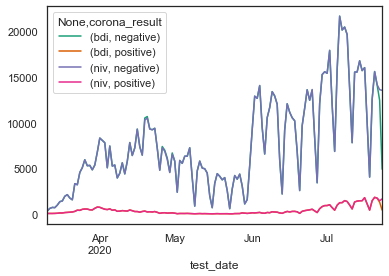

In [435]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

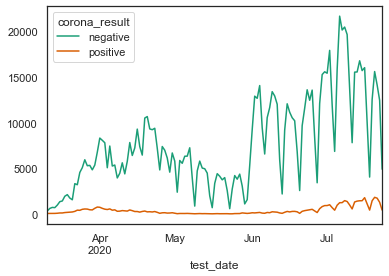

In [436]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [437]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='No')].groupby(['test_date', 'corona_result']).size().unstack()

corona_result,negative,positive
test_date,,
2020-03-11,3,3
2020-03-12,20,6
2020-03-13,17,2
2020-03-14,25,3
2020-03-15,70,45
...,...,...
2020-07-19,10836,1098
2020-07-20,12797,1326
2020-07-21,11670,1492


In [438]:
pone = bdi[(bdi.test_date<'2021') & (bdi.is_first_Test=='Yes')].fillna('Other').groupby(['test_date', 'corona_result']).size().unstack()
pone[pone.positive<20]

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-05-02,36.0,NaN,2375.0,18.0,NaN
2020-05-08,27.0,NaN,3947.0,18.0,NaN
2020-05-09,31.0,NaN,849.0,9.0,NaN
2020-05-12,46.0,NaN,5021.0,19.0,NaN
2020-05-14,60.0,1.0,4469.0,16.0,NaN
2020-05-15,28.0,NaN,1979.0,7.0,NaN
2020-05-16,24.0,NaN,675.0,4.0,NaN
2020-05-17,59.0,NaN,3341.0,15.0,NaN
2020-05-19,32.0,NaN,4124.0,12.0,NaN


In [439]:
pone.tail(5)

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-07-19,159.0,NaN,12532.0,1437.0,NaN
2020-07-20,272.0,NaN,15609.0,1812.0,NaN
2020-07-21,168.0,NaN,14135.0,1719.0,NaN
2020-07-22,141.0,NaN,12460.0,1273.0,NaN
2020-07-23,61.0,NaN,4892.0,411.0,NaN


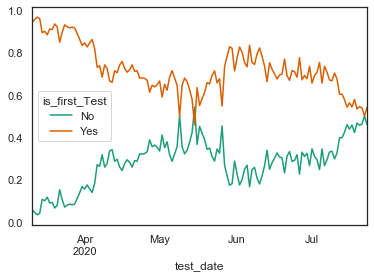

In [440]:
ti = bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

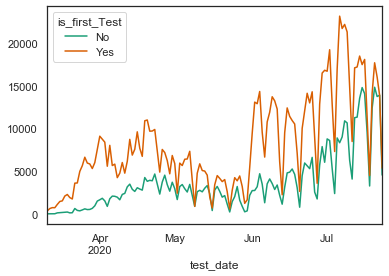

In [441]:
ti.plot()

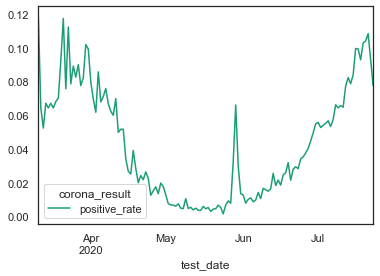

In [442]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative))[['positive_rate']]
 .plot())

In [443]:
import altair as alt
ti.tail()

is_first_Test,No,Yes
test_date,,
2020-07-19,12379,14128
2020-07-20,14828,17693
2020-07-21,13745,16022
2020-07-22,13900,13874
2020-07-23,4558,5364


In [444]:
ti.Yes.sum() + ti.No.sum()

1591234

In [445]:
alt.Chart(ti.reset_index().assign(total=lambda x: x.Yes+x.No)).mark_line().encode(
    x='test_date',
    y='Yes',
    tooltip=['test_date', 'Yes']
).interactive()

alt.Chart(...)

In [446]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [447]:
alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive']
).interactive()

alt.Chart(...)

In [448]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'חולים בינוני': 'medium',
            'מונשמים': 'resp'}

In [449]:
hos = (pd.read_csv(get_latest_file_glob('data/corona_hospitalization_ver_*.csv.gz'), encoding='utf-8-sig', low_memory=False, na_values=['None'])
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.str.replace('<15', '15').astype(int))
      .assign(medium = lambda x: x.medium.fillna('<15').str.replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.str.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.head()

,date,מאושפזים,אחוז נשים מאושפזות,גיל ממוצע מאושפזים,סטיית תקן גיל מאושפזים,resp,אחוז נשים מונשמות,גיל ממוצע מונשמים,סטיית תקן גיל מונשמים,חולים קל,...,גיל ממוצע חולים קל,סטיית תקן גיל חולים קל,medium,אחוז נשים חולות בינוני,גיל ממוצע חולים בינוני,סטיית תקן גיל חולים בינוני,critical,אחוז נשים חולות קשה,גיל ממוצע חולים קשה,סטיית תקן גיל חולים קשה
0,2020-03-11,75,36.0,48.0,17.4,15,20.0,63.0,15.3,68,...,47.0,16.8,15,NaN,NaN,NaN,15,33.3,67.0,16.2
1,2020-03-12,97,39.2,50.0,18.0,15,20.0,63.0,15.3,90,...,49.0,17.7,15,NaN,NaN,NaN,15,33.3,67.0,16.2
2,2020-03-13,115,39.1,49.0,18.0,15,20.0,63.0,15.3,105,...,47.0,17.4,15,50.0,64.0,17.3,15,33.3,67.0,16.2
3,2020-03-14,153,41.2,47.0,18.3,15,0.0,70.0,7.4,144,...,46.0,17.5,15,50.0,64.0,17.3,15,20.0,76.0,10.3
4,2020-03-15,192,44.3,46.0,18.6,15,20.0,74.0,7.6,178,...,45.0,17.6,15,50.0,58.0,14.9,15,37.5,79.0,9.1


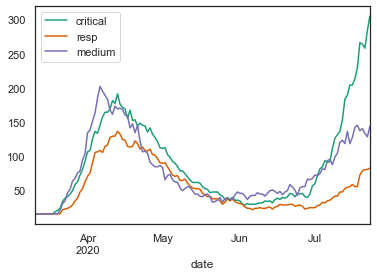

In [450]:
(hos[['date', 'critical', 'resp', 'medium']].set_index('date').plot())

In [451]:
hos_and_rate = hos[['date', 'critical', 'resp', 'medium']].rename(columns={'date': 'test_date'}).merge(pr, on='test_date')
hos_and_rate.head()


,test_date,critical,resp,medium,negative,positive,positive_rate
0,2020-03-11,15,15,15,319,43,0.118785
1,2020-03-12,15,15,15,597,41,0.064263
2,2020-03-13,15,15,15,706,39,0.052349
3,2020-03-14,15,15,15,681,49,0.067123
4,2020-03-15,15,15,15,960,66,0.064327


In [452]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [453]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.12]
               .assign(positive = lambda x: x.positive.ewm(span=7).mean())
               .assign(positive_label ='positive')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positives (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

No handles with labels found to put in legend.


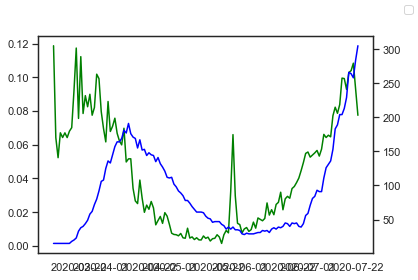

In [454]:
sns.lineplot(data=hos_and_rate[hos_and_rate.positive_rate<0.12].set_index('test_date').positive_rate, color="g")
ax2 = plt.twinx()
sns.lineplot(data=hos_and_rate.set_index('test_date').critical, color="b", ax=ax2)
ax2.figure.legend()


In [455]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical+med')
               .assign(crit_med = lambda x: (x.critical+x.medium).ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_med',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [456]:
hos_and_rate['pos_pct_change'] = hos_and_rate.positive_rate.pct_change()
hos_and_rate['crit_pct_change'] = hos_and_rate.critical.pct_change()


In [457]:
c1 = alt.Chart(hos_and_rate
               .assign(pos_pct_change = lambda x: x.pos_pct_change.ewm(span=7).mean())
              ).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='pos_pct_change',
    tooltip=['test_date', 'positive_rate'],
)
c2 = alt.Chart(hos_and_rate
               .assign(crit_pct_change = lambda x: x.crit_pct_change.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_pct_change',
    tooltip=['test_date', 'critical'],
)


alt.layer(c1, c2).properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

## Positive rate by Lab

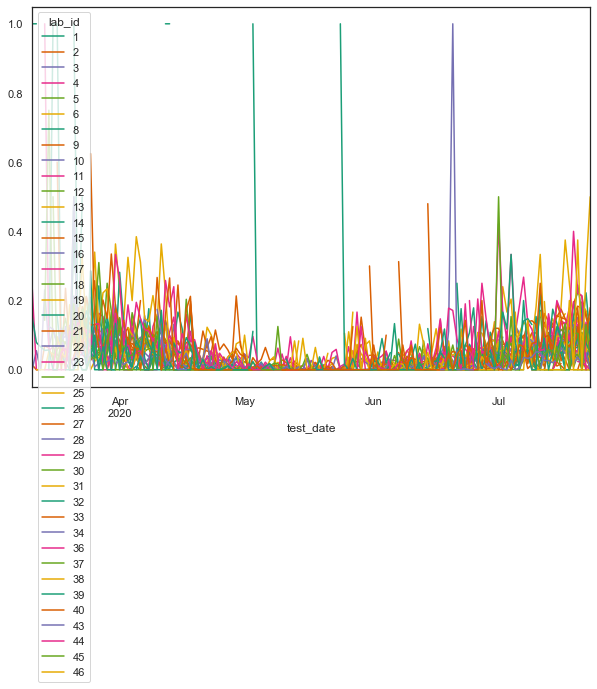

In [458]:
polab = bdi[(bdi.test_date<'2021') & (bdi.is_first_Test=='Yes')].fillna('Other').groupby(['test_date', 'lab_id', 'corona_result']).size().unstack().fillna(0)
polab['total_tests'] = polab.sum(axis=1)
polab['positive_rate'] = polab.positive/(polab.positive+polab.negative)
polab.positive_rate.unstack().plot(figsize=(10,7))

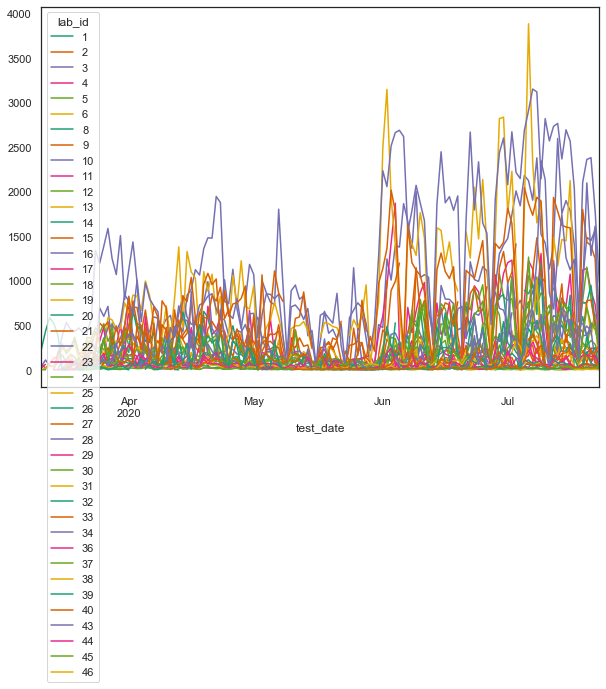

In [459]:
polab.total_tests.unstack().plot(figsize=(10,7))

In [460]:
(polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1)))

corona_result,positive,negative,total_tests,positive_rate
lab_id,,,,
16,7717.0,141853.0,150046.0,2.7
3,5083.0,119672.0,125860.0,2.1
13,5168.0,104354.0,112534.0,2.5
21,6947.0,79526.0,86826.0,4.4
4,2004.0,52324.0,54929.0,1.9
10,2026.0,48968.0,52199.0,2.1
15,3446.0,46546.0,50508.0,3.7
12,1788.0,38679.0,41235.0,2.3
27,506.0,36976.0,37494.0,0.7


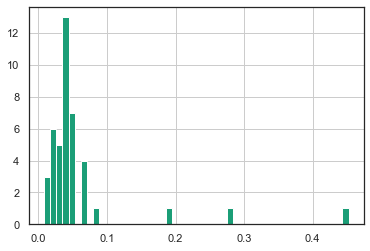

In [461]:
polab.reset_index().groupby('lab_id').positive_rate.mean().hist(bins=50)

In [462]:
top_5_labs = bdi.lab_id.value_counts().index[:5]
top_5_labs

Int64Index([3, 16, 13, 21, 43], dtype='int64')

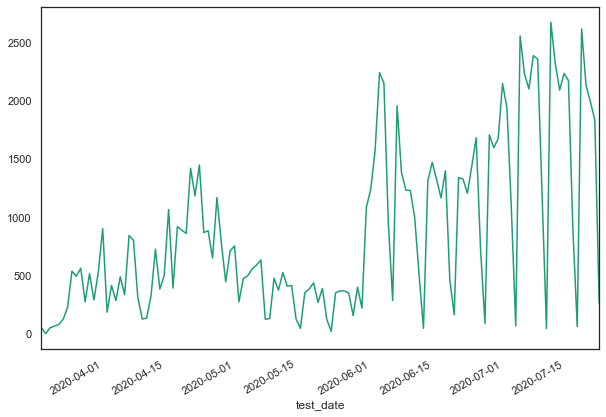

In [463]:
bdi[(bdi.lab_id==21)].groupby('test_date').size().plot(figsize=(10,7))

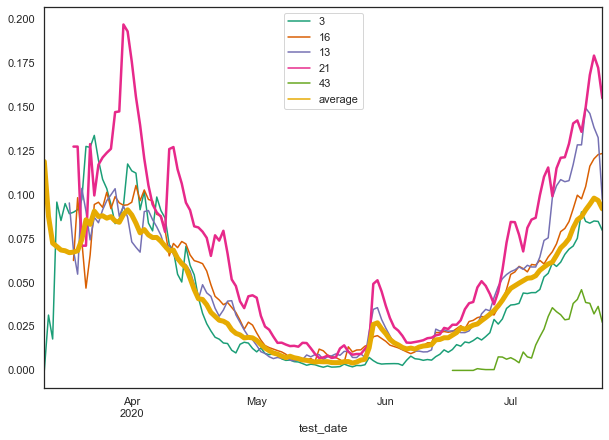

In [464]:
sns.set_palette(['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02'])
ax = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1).ewm(span=7).mean().plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=[1.5,1.5,1.5,2.5,1.5,5][i])


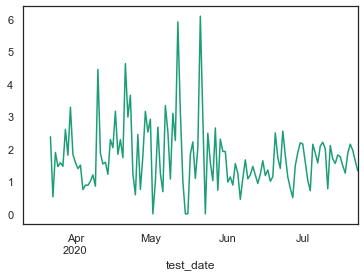

In [465]:
top_labs_pr = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1)
top_labs_pr['ratio_21'] = top_labs_pr.loc[:, 21]/top_labs_pr.average
top_labs_pr.ratio_21.plot()

In [466]:
bdi[bdi.lab_id==21].shape[0]/bdi.shape[0]

0.06979551718980363

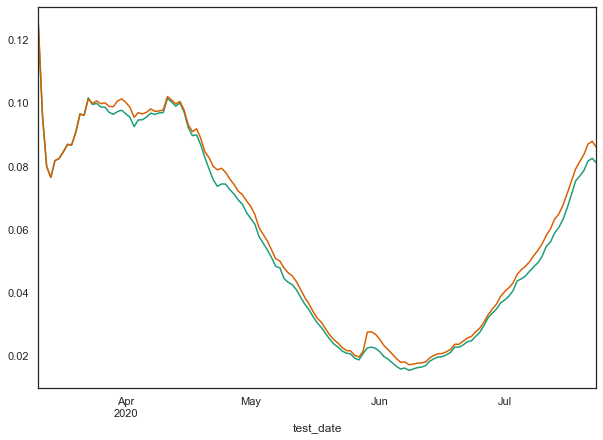

In [467]:
ax = (bdi[bdi.lab_id!=21].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo.ewm(7).mean().plot(figsize=(10,7))
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr.ewm(7).mean().plot(ax=ax, figsize=(10,7))

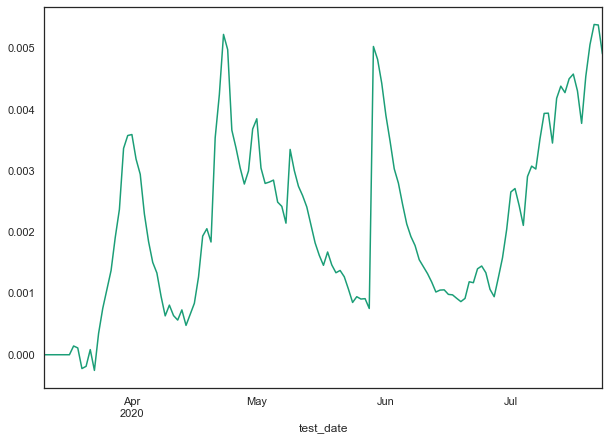

In [468]:
pd.concat([(bdi[bdi.lab_id!=21].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo,
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr], axis=1).assign(dif = lambda x: x.pr-x.pr_wo).dif.ewm(7).mean().plot(figsize=(10,7))

## Decseased 

In [469]:
last_dec = pd.read_csv(get_latest_file_glob('data/corona_deceased_ver*.csv.gz'), 
                       encoding='utf-8-sig', low_memory=False)
last_dec['qc'] = pd.qcut(last_dec.Length_of_hospitalization, 11)
last_dec.qc.value_counts().sort_index()/len(last_dec)

(-0.001, 1.0]      0.141573
(1.0, 3.0]         0.076404
(3.0, 5.0]         0.096629
(5.0, 6.0]         0.065169
(6.0, 8.0]         0.094382
(8.0, 9.364]       0.062921
(9.364, 12.0]      0.116854
(12.0, 15.0]       0.074157
(15.0, 21.0]       0.080899
(21.0, 32.273]     0.085393
(32.273, 107.0]    0.089888
Name: qc, dtype: float64

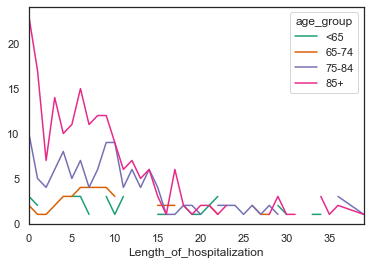

In [470]:
x = last_dec[last_dec['Length_of_hospitalization']<40].groupby(['Length_of_hospitalization', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.plot()

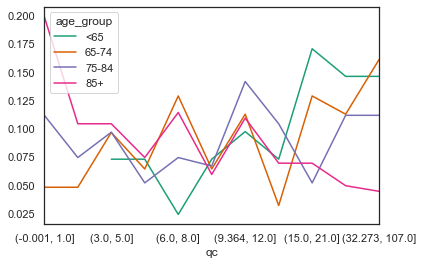

In [471]:
x = last_dec.groupby(['qc', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=0), axis=1).plot()

In [472]:
(last_dec.Length_of_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

0.0    0.085393
1.0    0.056180
2.0    0.026966
3.0    0.049438
4.0    0.047191
5.0    0.049438
6.0    0.065169
7.0    0.044944
8.0    0.049438
9.0    0.062921
Name: Length_of_hospitalization, dtype: float64

In [473]:
(last_dec.Time_between_positive_and_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

-36.0    0.002247
-21.0    0.002247
-15.0    0.002247
-14.0    0.002247
-9.0     0.002247
-8.0     0.002247
-6.0     0.002247
-5.0     0.002247
-4.0     0.006742
-3.0     0.004494
Name: Time_between_positive_and_hospitalization, dtype: float64

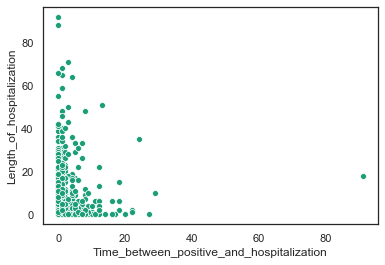

In [474]:
sns.scatterplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='Time_between_positive_and_hospitalization', y='Length_of_hospitalization')

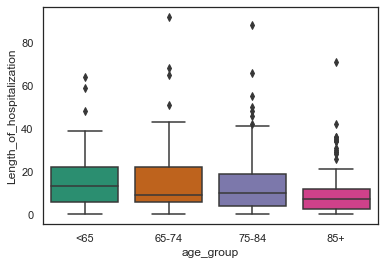

In [475]:
sns.boxplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='age_group', y='Length_of_hospitalization', order=['<65', '65-74', '75-84', '85+'])

In [476]:
decs = []
for file in sorted(glob.glob('data/corona_deceased_ver*.csv.gz'), key=os.path.getctime) :
    dec = pd.read_csv(file, 
                  encoding='utf-8-sig', low_memory=False)
    dec['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    dec.time = dec.time
    dec['file'] = file
    decs.append(dec)

decs = pd.concat(decs).sort_values('time')
decs.head()

,gender,age_group,Ventilated,Time_between_positive_and_hospitalization,Length_of_hospitalization,Time_between_positive_and_death,time,file
0,זכר,<65,1.0,2.0,20.0,22,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
203,נקבה,75-84,1.0,0.0,12.0,12,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
202,נקבה,85+,0.0,10.0,1.0,11,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
201,נקבה,85+,0.0,2.0,17.0,19,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
200,זכר,85+,1.0,0.0,9.0,9,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz


In [477]:
decs.shape, (decs.drop_duplicates(subset=['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death']).shape)

((4120, 8), (403, 8))

In [478]:
decs.columns

Index(['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death', 'time',
       'file'],
      dtype='object')

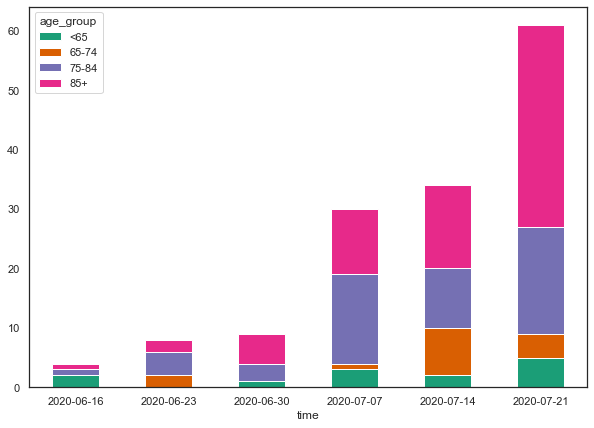

In [484]:
dec_dif = decs.groupby(['time', 'age_group']).size().unstack().diff()

dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

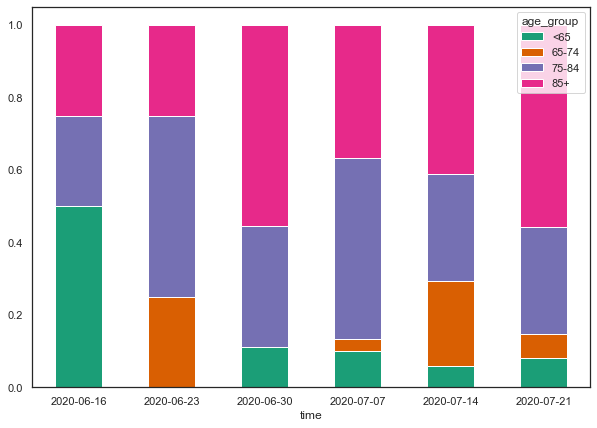

In [489]:
x = dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

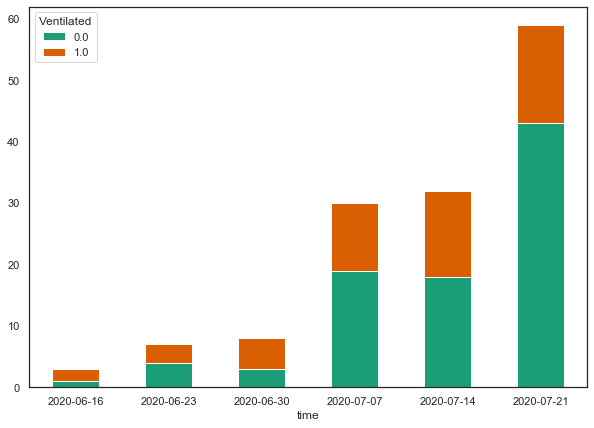

In [480]:
dec_dif = decs.groupby(['time', 'Ventilated']).size().unstack().diff()

dec_dif.resample('7d', kind='period').sum().plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

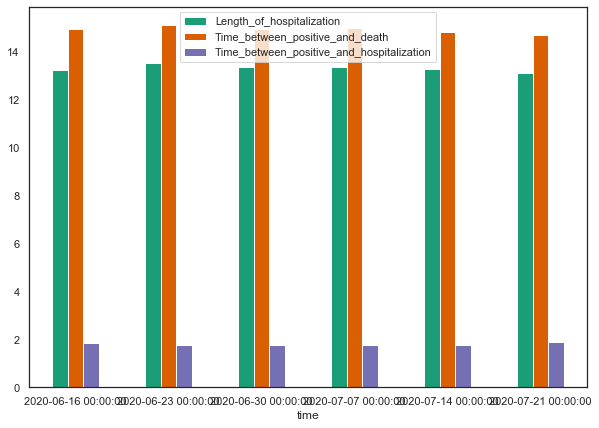

In [481]:
decs.resample('7d', on='time')[['Length_of_hospitalization', 'Time_between_positive_and_death', 'Time_between_positive_and_hospitalization']].mean().plot(kind='bar', figsize=(10,7), rot=0)


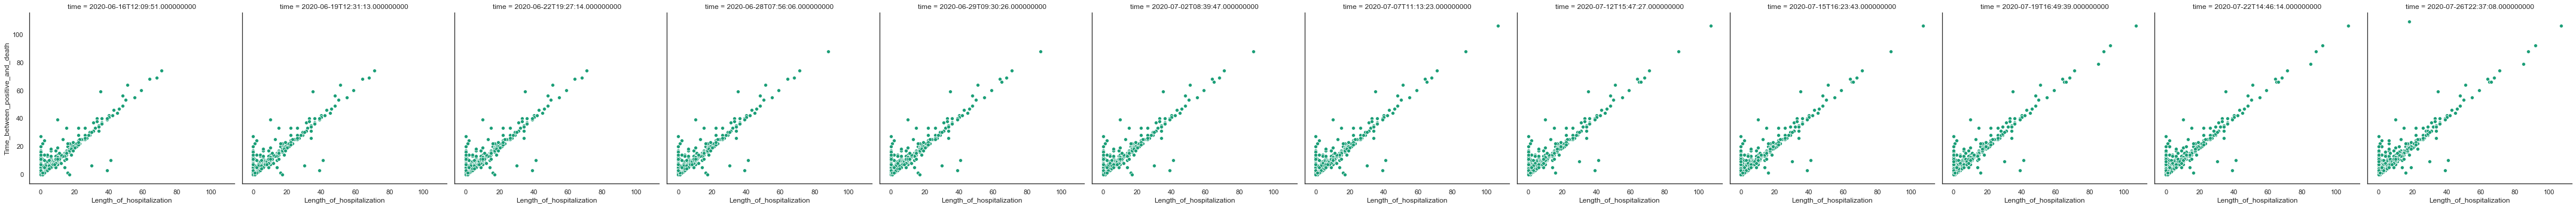

In [482]:
sns.relplot(data=decs, col='time', x='Length_of_hospitalization', y='Time_between_positive_and_death', kind='scatter')